## Starting and configuring our spark master and session

In [1]:
from pyspark.sql.types import StructType
format = StructType().add("Code", "string").add("Name", "string").add("latitude","float").add("longtitude","float")


In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
#import geopandas
import datetime



In [3]:
#sc = SparkContext()

spark = SparkSession.builder \
                .master('spark://master:7077') \
                .appName("cebd1261") \
                .getOrCreate()

### *reading the data related to the stations like:
#### *station code
#### * latitude and longtitude of the station
#### * the name of the station

In [4]:
df_station = spark.read.csv('gs://infra_project/Stations_2019.csv',schema=format, header="true")
df_station.show(5)


+-----+--------------------+---------+----------+
| Code|                Name| latitude|longtitude|
+-----+--------------------+---------+----------+
|10002|Métro Charlevoix ...| 45.47823| -73.56965|
| 4000|Jeanne-d'Arc / On...|  45.5496| -73.54188|
| 4001| Graham / Brookfield|45.520073|-73.629776|
| 4002|  Graham / Wicksteed|45.516937| -73.64048|
| 5002|St-Charles / Mont...|45.533684| -73.51526|
+-----+--------------------+---------+----------+
only showing top 5 rows



## Reading  data  for october loaded onto Google cloud 

In [5]:
df_2019_10=spark.read.csv('gs://infra_project/OD_2019-10.csv', header="true")


### we can see the the information for each day as:
#### dot: start and end staion codes
### :dot how much time each ride took
### :dot whether the rider is a member or not

In [6]:
df_2019_10.show()

+-------------------+------------------+-------------------+----------------+------------+---------+
|         start_date|start_station_code|           end_date|end_station_code|duration_sec|is_member|
+-------------------+------------------+-------------------+----------------+------------+---------+
|2019-10-01 00:00:08|              6174|2019-10-01 00:03:28|            6175|         199|        1|
|2019-10-01 00:01:13|              6196|2019-10-01 00:04:38|            6196|         205|        1|
|2019-10-01 00:01:34|              6033|2019-10-01 00:05:07|            6723|         212|        1|
|2019-10-01 00:02:33|              6136|2019-10-01 00:06:50|            6165|         256|        1|
|2019-10-01 00:02:34|              6204|2019-10-01 00:04:18|            6079|         104|        1|
|2019-10-01 00:02:49|              6052|2019-10-01 00:12:45|            6052|         596|        1|
|2019-10-01 00:04:07|              6149|2019-10-01 00:12:31|            6376|         503| 

### aggregating information to see how many rides were done from each station during the moonth 

In [7]:
station_cnt = df_2019_10.groupBy('start_station_code').agg({'start_station_code':'count'})
station_cnt.show()

+------------------+-------------------------+
|start_station_code|count(start_station_code)|
+------------------+-------------------------+
|              6194|                     2301|
|              6731|                      271|
|              6240|                      383|
|              6248|                     3293|
|              6366|                      537|
|              6903|                     2108|
|              7056|                      301|
|              6081|                      358|
|              6227|                     2535|
|              7054|                      696|
|              6380|                      547|
|              6106|                      520|
|              6732|                      608|
|              6143|                     1911|
|              6252|                     1152|
|              6402|                      722|
|              7014|                     1635|
|              7013|                      375|
|            

In [8]:
station_cnt = station_cnt.withColumnRenamed('start_station_code','code').withColumnRenamed('count(start_station_code)','October count')
station_cnt.show()
station_cnt = df_station.join(station_cnt,on='code')
station_cnt.show()

+----+-------------+
|code|October count|
+----+-------------+
|6194|         2301|
|6731|          271|
|6240|          383|
|6248|         3293|
|6366|          537|
|6903|         2108|
|7056|          301|
|6081|          358|
|6227|         2535|
|7054|          696|
|6380|          547|
|6106|          520|
|6732|          608|
|6143|         1911|
|6252|         1152|
|6402|          722|
|7014|         1635|
|7013|          375|
|6033|          424|
|7093|           42|
+----+-------------+
only showing top 20 rows

+----+--------------------+---------+----------+-------------+
|Code|                Name| latitude|longtitude|October count|
+----+--------------------+---------+----------+-------------+
|6194|Métro Atwater (At...|45.489475|-73.584564|         2301|
|6731|28e avenue / Rose...|45.564354| -73.57124|          271|
|6240|Parc Kent (de Ken...|45.505722|-73.629456|          383|
|6248|St-Dominique / Ra...|45.518593|-73.581566|         3293|
|6366|Wilderton  / Van ...|45

In [9]:
def sameday(day1,day2):
    if day1==day2:
        same_day=1
        print('yes')
    else:
        same_day=0
    return(same_day)

spark.udf.register("Check_same_day", sameday)

<function __main__.Check_same_day>

In [10]:
from  pyspark.sql.functions import month,year,dayofmonth,monotonically_increasing_id,udf,struct 
from pyspark.sql.types import IntegerType



q=df_2019_10.select(year(df_2019_10.start_date),month(df_2019_10.start_date),dayofmonth(df_2019_10.start_date),dayofmonth(df_2019_10.end_date))


q=q.withColumnRenamed('month(start_date)','month').withColumnRenamed('year(start_date)','year').withColumnRenamed('dayofmonth(start_date)','sday').withColumnRenamed('dayofmonth(end_date)','end_day')

q = q.withColumn('index',monotonically_increasing_id())  
df_2019_10 = df_2019_10.withColumn('index',monotonically_increasing_id())  

df_2019_10=df_2019_10.join(q,on='index')



In [11]:
check_udf = udf(sameday, IntegerType())


df_2019_10=df_2019_10.withColumn('same',check_udf('sday','end_day'))



In [12]:

df_2019_10_small = df_2019_10.drop('end_station_code','end_date')
print(df_2019_10_small.show())

+-----+-------------------+------------------+------------+---------+----+-----+----+-------+----+
|index|         start_date|start_station_code|duration_sec|is_member|year|month|sday|end_day|same|
+-----+-------------------+------------------+------------+---------+----+-----+----+-------+----+
|    0|2019-10-01 00:00:08|              6174|         199|        1|2019|   10|   1|      1|   1|
|    1|2019-10-01 00:01:13|              6196|         205|        1|2019|   10|   1|      1|   1|
|    2|2019-10-01 00:01:34|              6033|         212|        1|2019|   10|   1|      1|   1|
|    3|2019-10-01 00:02:33|              6136|         256|        1|2019|   10|   1|      1|   1|
|    4|2019-10-01 00:02:34|              6204|         104|        1|2019|   10|   1|      1|   1|
|    5|2019-10-01 00:02:49|              6052|         596|        1|2019|   10|   1|      1|   1|
|    6|2019-10-01 00:04:07|              6149|         503|        1|2019|   10|   1|      1|   1|
|    7|201

In [13]:
df_2019_10_agg=df_2019_10.groupBy('year','month','sday').agg({'sday':'count','duration_sec':'mean'})
df_2019_10_agg=df_2019_10_agg.orderBy('sday')
df_2019_10_agg.show(31)


+----+-----+----+-----------+-----------------+
|year|month|sday|count(sday)|avg(duration_sec)|
+----+-----+----+-----------+-----------------+
|2019|   10|   1|      14017| 636.348148676607|
|2019|   10|   2|      26547|679.7920292311749|
|2019|   10|   3|      24542|670.0463694890392|
|2019|   10|   4|      23822| 685.766392410377|
|2019|   10|   5|      19613|773.0914189568143|
|2019|   10|   6|      15544|688.2258749356665|
|2019|   10|   7|      18289|664.0854612061895|
|2019|   10|   8|      28226|722.1517395309289|
|2019|   10|   9|      26730|702.8726898615788|
|2019|   10|  10|      27761|713.6801988400994|
|2019|   10|  11|      27242| 733.204573819837|
|2019|   10|  12|      18073|797.5678636640292|
|2019|   10|  13|      17879|840.4145086414229|
|2019|   10|  14|      13734|721.5892675112858|
|2019|   10|  15|      24828|693.0045513130336|
|2019|   10|  16|      22370|682.5941439427805|
|2019|   10|  17|       5616| 541.031339031339|
|2019|   10|  18|      21218|664.1704213

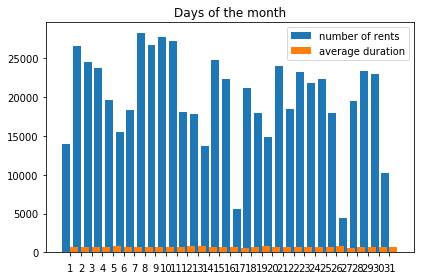

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

df_2019_10_pd=df_2019_10_agg.toPandas()
df_2019_10_pd.sort_values('sday',inplace=True)
labels = df_2019_10_pd['sday']


x = np.arange(31)  # the label locations
width = 0.75 # the width of the bars
plt.figure(figsize=(40,100))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_2019_10_pd['count(sday)'], width, label='number of rents')
rects2 = ax.bar(x + width/2, df_2019_10_pd['avg(duration_sec)'], width, label='average duration')

# Add some text for labels, title and custom x-axis tick labels, etc.



ax.set_ylabel('')
ax.set_title('Days of the month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tick_params(axis='x', which='major', labelsize=10,pad=7)

plt.tight_layout()

plt.show()

In [15]:
df_2019_09=spark.read.csv('gs://infra_project/OD_2019-09.csv', header="true")

In [16]:
df_2019_09.show(10)

+-------------------+------------------+-------------------+----------------+------------+---------+
|         start_date|start_station_code|           end_date|end_station_code|duration_sec|is_member|
+-------------------+------------------+-------------------+----------------+------------+---------+
|2019-09-01 00:00:04|              6205|2019-09-01 00:08:15|            6248|         490|        1|
|2019-09-01 00:00:08|              6110|2019-09-01 00:03:51|            6120|         223|        1|
|2019-09-01 00:00:09|              6202|2019-09-01 00:20:24|            6143|        1214|        0|
|2019-09-01 00:00:10|              6196|2019-09-01 00:13:26|            6040|         795|        1|
|2019-09-01 00:00:12|              6014|2019-09-01 00:08:45|            6132|         512|        1|
|2019-09-01 00:00:12|              6181|2019-09-01 00:13:03|            6915|         771|        0|
|2019-09-01 00:00:12|              6181|2019-09-01 00:13:06|            6915|         774| 

In [17]:
q=df_2019_09.select(year(df_2019_09.start_date),month(df_2019_09.start_date),dayofmonth(df_2019_09.start_date),dayofmonth(df_2019_09.end_date))


q=q.withColumnRenamed('month(start_date)','month').withColumnRenamed('year(start_date)','year').withColumnRenamed('dayofmonth(start_date)','sday').withColumnRenamed('dayofmonth(end_date)','end_day')

q = q.withColumn('index',monotonically_increasing_id())  
df_2019_09 = df_2019_09.withColumn('index',monotonically_increasing_id())  

df_2019_09=df_2019_09.join(q,on='index')

In [18]:
df_2019_09_agg=df_2019_09.groupBy('year','month','sday').agg({'sday':'count','duration_sec':'mean'})
df_2019_09_agg=df_2019_09_agg.orderBy('sday')
df_2019_09_agg.show(31)

+----+-----+----+-----------+-----------------+
|year|month|sday|count(sday)|avg(duration_sec)|
+----+-----+----+-----------+-----------------+
|2019|    9|   1|      29560|945.2559878213802|
|2019|    9|   2|      14531| 781.265363705182|
|2019|    9|   3|      34972|779.1497483701247|
|2019|    9|   4|      28858|739.8015108462125|
|2019|    9|   5|      36933|778.5089757127772|
|2019|    9|   6|      35358|773.2338650376153|
|2019|    9|   7|      19925|782.7661731493099|
|2019|    9|   8|      22494|801.4959989330488|
|2019|    9|   9|      31544|759.2136380928227|
|2019|    9|  10|      26572|716.2924883335842|
|2019|    9|  11|      31520|737.6217322335025|
|2019|    9|  12|      34834|762.4353505196073|
|2019|    9|  13|      34314|774.4243166054672|
|2019|    9|  14|      23734|807.3152439538216|
|2019|    9|  15|      23524|830.5866774358102|
|2019|    9|  16|      31803|765.0134892934628|
|2019|    9|  17|      33798|763.6537960826084|
|2019|    9|  18|      33749|749.8046756

In [19]:
df_2019_08=spark.read.csv('gs://infra_project/OD_2019-08.csv', header="true")

In [20]:
df_2019_08.show(10)

+-------------------+------------------+-------------------+----------------+------------+---------+
|         start_date|start_station_code|           end_date|end_station_code|duration_sec|is_member|
+-------------------+------------------+-------------------+----------------+------------+---------+
|2019-08-01 00:00:03|              7032|2019-08-01 00:24:57|            6159|        1493|        1|
|2019-08-01 00:00:04|              6219|2019-08-01 00:08:20|            6201|         495|        1|
|2019-08-01 00:00:04|              6368|2019-08-01 00:10:14|            4000|         609|        1|
|2019-08-01 00:00:19|              6154|2019-08-01 00:09:27|            6163|         547|        1|
|2019-08-01 00:00:26|              6039|2019-08-01 00:21:14|            6402|        1247|        1|
|2019-08-01 00:00:27|              7027|2019-08-01 00:19:12|            7017|        1124|        1|
|2019-08-01 00:00:39|              6147|2019-08-01 00:08:51|            6169|         492| 

In [21]:
q=df_2019_08.select(year(df_2019_08.start_date),month(df_2019_08.start_date),dayofmonth(df_2019_08.start_date),dayofmonth(df_2019_08.end_date))


q=q.withColumnRenamed('month(start_date)','month').withColumnRenamed('year(start_date)','year').withColumnRenamed('dayofmonth(start_date)','sday').withColumnRenamed('dayofmonth(end_date)','end_day')

q = q.withColumn('index',monotonically_increasing_id())  
df_2019_08 = df_2019_08.withColumn('index',monotonically_increasing_id())  

df_2019_08=df_2019_08.join(q,on='index')

In [22]:
df_2019_08_agg=df_2019_08.groupBy('year','month','sday').agg({'sday':'count','duration_sec':'mean'})
df_2019_08_agg=df_2019_08_agg.orderBy('sday')
df_2019_08_agg.show(31)

+----+-----+----+-----------+-----------------+
|year|month|sday|count(sday)|avg(duration_sec)|
+----+-----+----+-----------+-----------------+
|2019|    8|   1|      39832|822.5363275758184|
|2019|    8|   2|      39036|843.7139819653653|
|2019|    8|   3|      33340|924.8182063587283|
|2019|    8|   4|      32823|958.9251134874935|
|2019|    8|   5|      36820|839.6556762629006|
|2019|    8|   6|      36854|804.3845444185163|
|2019|    8|   7|      32433|769.0673696543644|
|2019|    8|   8|      34300|808.0719241982507|
|2019|    8|   9|      33235|788.1301338949902|
|2019|    8|  10|      26591|868.9100071452747|
|2019|    8|  11|      29932|919.8949285046104|
|2019|    8|  12|      28722|782.6780864842282|
|2019|    8|  13|      36227|819.6789687249841|
|2019|    8|  14|      36785|811.8061709936115|
|2019|    8|  15|      38273|822.4714289446869|
|2019|    8|  16|      36938|827.8803671016298|
|2019|    8|  17|      29427|888.6066197709587|
|2019|    8|  18|      29783| 897.579860

In [23]:
df_2019_07=spark.read.csv('gs://infra_project/OD_2019-07.csv', header="true")

In [24]:
df_2019_07.show(10)

+-------------------+------------------+-------------------+----------------+------------+---------+
|         start_date|start_station_code|           end_date|end_station_code|duration_sec|is_member|
+-------------------+------------------+-------------------+----------------+------------+---------+
|2019-07-01 00:00:03|              6014|2019-07-01 00:04:26|            6023|         262|        1|
|2019-07-01 00:00:07|              6036|2019-07-01 00:34:54|            6052|        2087|        0|
|2019-07-01 00:00:11|              6018|2019-07-01 00:06:48|            6148|         396|        1|
|2019-07-01 00:00:12|              6202|2019-07-01 00:17:25|            6280|        1032|        1|
|2019-07-01 00:00:15|              6018|2019-07-01 00:06:57|            6148|         401|        1|
|2019-07-01 00:00:20|              6248|2019-07-01 00:15:40|            6113|         920|        1|
|2019-07-01 00:00:37|              6268|2019-07-01 00:15:00|            6195|         862| 

In [25]:
q=df_2019_07.select(year(df_2019_07.start_date),month(df_2019_07.start_date),dayofmonth(df_2019_07.start_date),dayofmonth(df_2019_07.end_date))


q=q.withColumnRenamed('month(start_date)','month').withColumnRenamed('year(start_date)','year').withColumnRenamed('dayofmonth(start_date)','sday').withColumnRenamed('dayofmonth(end_date)','end_day')

q = q.withColumn('index',monotonically_increasing_id())  
df_2019_07 = df_2019_07.withColumn('index',monotonically_increasing_id())  

df_2019_07=df_2019_07.join(q,on='index')

In [26]:
df_2019_07_agg=df_2019_07.groupBy('year','month','sday').agg({'sday':'count','duration_sec':'mean'})
df_2019_07_agg=df_2019_07_agg.orderBy('sday')
df_2019_07_agg.show(31)

+----+-----+----+-----------+-----------------+
|year|month|sday|count(sday)|avg(duration_sec)|
+----+-----+----+-----------+-----------------+
|2019|    7|   1|      32084|994.5015584091759|
|2019|    7|   2|      40388| 854.530132712687|
|2019|    7|   3|      41063|846.8552955215157|
|2019|    7|   4|      40394|838.0419616774768|
|2019|    7|   5|      35603|848.3017161475157|
|2019|    7|   6|      33578| 947.518017749717|
|2019|    7|   7|      32911|954.6893743733099|
|2019|    7|   8|      36735|834.4443718524568|
|2019|    7|   9|      39216|829.4444359445124|
|2019|    7|  10|      40652|829.7019334842074|
|2019|    7|  11|      21666|731.8899196898366|
|2019|    7|  12|      36857|807.1630626475296|
|2019|    7|  13|      31164|914.8145616737261|
|2019|    7|  14|      28291|903.9676222120108|
|2019|    7|  15|      35924|832.2562075492707|
|2019|    7|  16|      36474|816.7771289137468|
|2019|    7|  17|      38966|819.0381101473079|
|2019|    7|  18|      40612|835.9533881

In [27]:
df_2019_06=spark.read.csv('gs://infra_project/OD_2019-06.csv', header="true")

In [28]:
df_2019_06.show(10)

+-------------------+------------------+-------------------+----------------+------------+---------+
|         start_date|start_station_code|           end_date|end_station_code|duration_sec|is_member|
+-------------------+------------------+-------------------+----------------+------------+---------+
|2019-06-01 00:00:03|              6026|2019-06-01 00:03:20|            6036|         197|        0|
|2019-06-01 00:00:06|              6197|2019-06-01 00:24:02|            6006|        1436|        1|
|2019-06-01 00:00:10|              6435|2019-06-01 00:11:53|            7082|         702|        1|
|2019-06-01 00:00:10|              7036|2019-06-01 00:21:40|            6213|        1289|        0|
|2019-06-01 00:00:11|              7003|2019-06-01 00:12:12|            6019|         721|        1|
|2019-06-01 00:00:19|              6750|2019-06-01 00:06:17|            6187|         358|        1|
|2019-06-01 00:00:26|              6203|2019-06-01 00:10:53|            6729|         627| 

In [29]:
q=df_2019_06.select(year(df_2019_06.start_date),month(df_2019_06.start_date),dayofmonth(df_2019_06.start_date),dayofmonth(df_2019_06.end_date))


q=q.withColumnRenamed('month(start_date)','month').withColumnRenamed('year(start_date)','year').withColumnRenamed('dayofmonth(start_date)','sday').withColumnRenamed('dayofmonth(end_date)','end_day')

q = q.withColumn('index',monotonically_increasing_id())  
df_2019_06 = df_2019_06.withColumn('index',monotonically_increasing_id())  

df_2019_06=df_2019_06.join(q,on='index')

In [30]:
df_2019_06_agg=df_2019_06.groupBy('year','month','sday').agg({'sday':'count','duration_sec':'mean'})
df_2019_06_agg=df_2019_06_agg.orderBy('sday')
df_2019_06_agg.show(31)

+----+-----+----+-----------+-----------------+
|year|month|sday|count(sday)|avg(duration_sec)|
+----+-----+----+-----------+-----------------+
|2019|    6|   1|      30223|901.0088674188532|
|2019|    6|   2|      15968| 782.349010521042|
|2019|    6|   3|      26354| 739.567959323063|
|2019|    6|   4|      28998|764.3596454927927|
|2019|    6|   5|      30092| 751.743187558155|
|2019|    6|   6|      38449|842.7290956851933|
|2019|    6|   7|      39123|852.9688929785548|
|2019|    6|   8|      37405|965.9522256382836|
|2019|    6|   9|      33545|959.9566552392309|
|2019|    6|  10|      34737|830.0423179894636|
|2019|    6|  11|      27856|748.3464603676048|
|2019|    6|  12|      37621| 837.155578001648|
|2019|    6|  13|      30093|759.9766723158209|
|2019|    6|  14|      24320|719.2187911184211|
|2019|    6|  15|      16271|751.0709237293344|
|2019|    6|  16|      29166|926.4559075636015|
|2019|    6|  17|      35625|838.5728842105264|
|2019|    6|  18|      38042|840.9814941

In [31]:
df_2019_05=spark.read.csv('gs://infra_project/OD_2019-05.csv', header="true")

In [32]:
df_2019_05.show(10)

+-------------------+------------------+-------------------+----------------+------------+---------+
|         start_date|start_station_code|           end_date|end_station_code|duration_sec|is_member|
+-------------------+------------------+-------------------+----------------+------------+---------+
|2019-05-01 00:00:19|              6902|2019-05-01 00:16:24|            6387|         965|        1|
|2019-05-01 00:00:33|              6171|2019-05-01 00:06:05|            6112|         331|        1|
|2019-05-01 00:01:12|              6073|2019-05-01 00:29:27|            6331|        1694|        1|
|2019-05-01 00:01:17|              6080|2019-05-01 00:09:34|            6080|         497|        1|
|2019-05-01 00:01:23|              6411|2019-05-01 00:04:49|            6012|         206|        1|
|2019-05-01 00:01:55|              6401|2019-05-01 00:10:32|            7041|         517|        1|
|2019-05-01 00:02:00|              6027|2019-05-01 00:24:54|            7042|        1374| 

In [33]:
q=df_2019_05.select(year(df_2019_05.start_date),month(df_2019_05.start_date),dayofmonth(df_2019_05.start_date),dayofmonth(df_2019_05.end_date))


q=q.withColumnRenamed('month(start_date)','month').withColumnRenamed('year(start_date)','year').withColumnRenamed('dayofmonth(start_date)','sday').withColumnRenamed('dayofmonth(end_date)','end_day')

q = q.withColumn('index',monotonically_increasing_id())  
df_2019_05 = df_2019_05.withColumn('index',monotonically_increasing_id())  

df_2019_05=df_2019_05.join(q,on='index')

In [34]:
df_2019_05_agg=df_2019_05.groupBy('year','month','sday').agg({'sday':'count','duration_sec':'mean'})
df_2019_05_agg=df_2019_05_agg.orderBy('sday')
df_2019_05_agg.show(31)

+----+-----+----+-----------+-----------------+
|year|month|sday|count(sday)|avg(duration_sec)|
+----+-----+----+-----------+-----------------+
|2019|    5|   1|      16549|685.0921505831168|
|2019|    5|   2|      19354|712.4081843546554|
|2019|    5|   3|      14502|688.2785133085092|
|2019|    5|   4|      25509|937.0463757889372|
|2019|    5|   5|      29123|976.8482642584898|
|2019|    5|   6|      31189|865.9842252076053|
|2019|    5|   7|      28516|791.5393463318838|
|2019|    5|   8|      28927|794.8418086908424|
|2019|    5|   9|      24751| 751.088238859036|
|2019|    5|  10|      13305|679.4142051860202|
|2019|    5|  11|      22437|831.6142532424121|
|2019|    5|  12|      23012| 892.687510863897|
|2019|    5|  13|      23715|731.4053130929791|
|2019|    5|  14|      14793|637.0627323734199|
|2019|    5|  15|      28480|775.9070926966292|
|2019|    5|  16|      31006|791.6428110688254|
|2019|    5|  17|      23506| 726.210244192972|
|2019|    5|  18|      23420|882.0932109

In [35]:
df_2019_04=spark.read.csv('gs://infra_project/OD_2019-04.csv', header="true")

In [36]:
df_2019_04.show(10)

+-------------------+------------------+-------------------+----------------+------------+---------+
|         start_date|start_station_code|           end_date|end_station_code|duration_sec|is_member|
+-------------------+------------------+-------------------+----------------+------------+---------+
|2019-04-14 07:55:22|              6001|2019-04-14 08:07:16|            6132|         713|        1|
|2019-04-14 07:59:31|              6411|2019-04-14 08:09:18|            6411|         587|        1|
|2019-04-14 07:59:55|              6097|2019-04-14 08:12:11|            6036|         736|        1|
|2019-04-14 07:59:57|              6310|2019-04-14 08:27:58|            6345|        1680|        1|
|2019-04-14 08:00:37|              7029|2019-04-14 08:14:12|            6250|         814|        0|
|2019-04-14 08:01:27|              6234|2019-04-14 08:08:02|            6215|         395|        1|
|2019-04-14 08:01:42|              7133|2019-04-14 08:11:31|            7129|         588| 

In [37]:
q=df_2019_04.select(year(df_2019_04.start_date),month(df_2019_04.start_date),dayofmonth(df_2019_04.start_date),dayofmonth(df_2019_04.end_date))


q=q.withColumnRenamed('month(start_date)','month').withColumnRenamed('year(start_date)','year').withColumnRenamed('dayofmonth(start_date)','sday').withColumnRenamed('dayofmonth(end_date)','end_day')

q = q.withColumn('index',monotonically_increasing_id())  
df_2019_04 = df_2019_04.withColumn('index',monotonically_increasing_id())  

df_2019_04=df_2019_04.join(q,on='index')

In [38]:
df_2019_04_agg=df_2019_04.groupBy('year','month','sday').agg({'sday':'count','duration_sec':'mean'})
df_2019_04_agg=df_2019_04_agg.orderBy('sday')
df_2019_04_agg.show(31)

+----+-----+----+-----------+------------------+
|year|month|sday|count(sday)| avg(duration_sec)|
+----+-----+----+-----------+------------------+
|2019|    4|  14|       9143| 868.4090561084982|
|2019|    4|  15|       7310| 653.9667578659371|
|2019|    4|  16|      13672| 715.0547103569339|
|2019|    4|  17|      19726|  806.916607523066|
|2019|    4|  18|      13505| 676.8959644576083|
|2019|    4|  19|       4673| 618.5182965974749|
|2019|    4|  20|       6604| 639.3069351907934|
|2019|    4|  21|      16306|1013.2635226297068|
|2019|    4|  22|      21354| 927.1408635384471|
|2019|    4|  23|      20897|  791.423505766378|
|2019|    4|  24|      10624| 648.4322289156627|
|2019|    4|  25|      20155| 743.7738526420243|
|2019|    4|  26|       8179| 623.4257244161878|
|2019|    4|  27|       7518| 605.6012237297153|
|2019|    4|  28|      14192| 792.2765642615558|
|2019|    4|  29|      20319| 757.1533540036419|
|2019|    4|  30|      23365| 767.3380269634068|
+----+-----+----+---

In [39]:
df_2019_agg= df_2019_04_agg.union(df_2019_05_agg)
df_2019_agg=df_2019_agg.union(df_2019_06_agg)
df_2019_agg=df_2019_agg.union(df_2019_07_agg)
df_2019_agg=df_2019_agg.union(df_2019_08_agg)
df_2019_agg=df_2019_agg.union(df_2019_09_agg)
df_2019_agg=df_2019_agg.union(df_2019_10_agg)

df_2019_agg.show(200)

+----+-----+----+-----------+------------------+
|year|month|sday|count(sday)| avg(duration_sec)|
+----+-----+----+-----------+------------------+
|2019|    4|  14|       9143| 868.4090561084982|
|2019|    4|  15|       7310| 653.9667578659371|
|2019|    4|  16|      13672| 715.0547103569339|
|2019|    4|  17|      19726|  806.916607523066|
|2019|    4|  18|      13505| 676.8959644576083|
|2019|    4|  19|       4673| 618.5182965974749|
|2019|    4|  20|       6604| 639.3069351907934|
|2019|    4|  21|      16306|1013.2635226297068|
|2019|    4|  22|      21354| 927.1408635384471|
|2019|    4|  23|      20897|  791.423505766378|
|2019|    4|  24|      10624| 648.4322289156627|
|2019|    4|  25|      20155| 743.7738526420243|
|2019|    4|  26|       8179| 623.4257244161878|
|2019|    4|  27|       7518| 605.6012237297153|
|2019|    4|  28|      14192| 792.2765642615558|
|2019|    4|  29|      20319| 757.1533540036419|
|2019|    4|  30|      23365| 767.3380269634068|
|2019|    5|   1|   

In [40]:
df_2019_agg=df_2019_agg.withColumnRenamed('count(sday)','rides per day').withColumnRenamed('avg(duration_sec)','average ride time/seconds')
df_2019_agg.show()

+----+-----+----+-------------+-------------------------+
|year|month|sday|rides per day|average ride time/seconds|
+----+-----+----+-------------+-------------------------+
|2019|    4|  14|         9143|        868.4090561084982|
|2019|    4|  15|         7310|        653.9667578659371|
|2019|    4|  16|        13672|        715.0547103569339|
|2019|    4|  17|        19726|         806.916607523066|
|2019|    4|  18|        13505|        676.8959644576083|
|2019|    4|  19|         4673|        618.5182965974749|
|2019|    4|  20|         6604|        639.3069351907934|
|2019|    4|  21|        16306|       1013.2635226297068|
|2019|    4|  22|        21354|        927.1408635384471|
|2019|    4|  23|        20897|         791.423505766378|
|2019|    4|  24|        10624|        648.4322289156627|
|2019|    4|  25|        20155|        743.7738526420243|
|2019|    4|  26|         8179|        623.4257244161878|
|2019|    4|  27|         7518|        605.6012237297153|
|2019|    4|  

In [41]:
from pyspark.sql.functions import concat,lit,col
x=df_2019_agg.select(concat(df_2019_agg.year, lit("/"),df_2019_agg.month,lit('/'),df_2019_agg.sday))
x.show()


+-------------------------------+
|concat(year, /, month, /, sday)|
+-------------------------------+
|                      2019/4/14|
|                      2019/4/15|
|                      2019/4/16|
|                      2019/4/17|
|                      2019/4/18|
|                      2019/4/19|
|                      2019/4/20|
|                      2019/4/21|
|                      2019/4/22|
|                      2019/4/23|
|                      2019/4/24|
|                      2019/4/25|
|                      2019/4/26|
|                      2019/4/27|
|                      2019/4/28|
|                      2019/4/29|
|                      2019/4/30|
|                       2019/5/1|
|                       2019/5/2|
|                       2019/5/3|
+-------------------------------+
only showing top 20 rows



In [42]:
x=x.withColumnRenamed('concat(year, /, month, /, sday)','Date')
x = x.withColumn('index',monotonically_increasing_id())  



In [43]:
df_2019_agg = df_2019_agg.withColumn('index',monotonically_increasing_id())  
x.show()
df_2019_agg.show()
df_2019_agg=df_2019_agg.join(x,on='index')
df_2019_agg.show()
df_2019_agg=df_2019_agg.drop('year','month','sday')
df_2019_agg.show()

+---------+------------+
|     Date|       index|
+---------+------------+
|2019/4/14|           0|
|2019/4/15|  8589934592|
|2019/4/16| 17179869184|
|2019/4/17| 25769803776|
|2019/4/18| 34359738368|
|2019/4/19| 42949672960|
|2019/4/20| 51539607552|
|2019/4/21| 60129542144|
|2019/4/22| 68719476736|
|2019/4/23| 77309411328|
|2019/4/24| 85899345920|
|2019/4/25| 94489280512|
|2019/4/26|103079215104|
|2019/4/27|111669149696|
|2019/4/28|120259084288|
|2019/4/29|128849018880|
|2019/4/30|137438953472|
| 2019/5/1|146028888064|
| 2019/5/2|154618822656|
| 2019/5/3|163208757248|
+---------+------------+
only showing top 20 rows

+----+-----+----+-------------+-------------------------+------------+
|year|month|sday|rides per day|average ride time/seconds|       index|
+----+-----+----+-------------+-------------------------+------------+
|2019|    4|  14|         9143|        868.4090561084982|           0|
|2019|    4|  15|         7310|        653.9667578659371|  8589934592|
|2019|    4|  16|  

In [44]:
df_2019_agg=df_2019_agg.orderBy('index')
df_2019_agg=df_2019_agg.drop('index')
df_2019_agg.show()

+-------------+-------------------------+---------+
|rides per day|average ride time/seconds|     Date|
+-------------+-------------------------+---------+
|         9143|        868.4090561084982|2019/4/14|
|         7310|        653.9667578659371|2019/4/15|
|        13672|        715.0547103569339|2019/4/16|
|        19726|         806.916607523066|2019/4/17|
|        13505|        676.8959644576083|2019/4/18|
|         4673|        618.5182965974749|2019/4/19|
|         6604|        639.3069351907934|2019/4/20|
|        16306|       1013.2635226297068|2019/4/21|
|        21354|        927.1408635384471|2019/4/22|
|        20897|         791.423505766378|2019/4/23|
|        10624|        648.4322289156627|2019/4/24|
|        20155|        743.7738526420243|2019/4/25|
|         8179|        623.4257244161878|2019/4/26|
|         7518|        605.6012237297153|2019/4/27|
|        14192|        792.2765642615558|2019/4/28|
|        20319|        757.1533540036419|2019/4/29|
|        233

In [45]:
from pyspark.sql.functions import to_date
d=df_2019_agg.select(to_date(df_2019_agg.Date,'yyyy/mm/dd'))

In [46]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

/opt/conda/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [47]:

d=d.withColumnRenamed("to_date(`Date`, 'yyyy/mm/dd')",'Date')
d = d.withColumn('index',monotonically_increasing_id())
df_2019_agg=df_2019_agg.drop('Date')
df_2019_agg = df_2019_agg.withColumn('index',monotonically_increasing_id())
df_2019_agg=df_2019_agg.join(d,on='index',how='left')
df_2019_agg=df_2019_agg.orderBy('index')
df_2019_agg=df_2019_agg.drop('index')
df_2019_agg.show()

+-------------+-------------------------+----------+
|rides per day|average ride time/seconds|      Date|
+-------------+-------------------------+----------+
|         9143|        868.4090561084982|2019-01-14|
|         7310|        653.9667578659371|2019-01-15|
|        13672|        715.0547103569339|2019-01-16|
|        19726|         806.916607523066|2019-01-17|
|        13505|        676.8959644576083|2019-01-18|
|         4673|        618.5182965974749|2019-01-19|
|         6604|        639.3069351907934|2019-01-20|
|        16306|       1013.2635226297068|2019-01-21|
|        21354|        927.1408635384471|2019-01-22|
|        20897|         791.423505766378|2019-01-23|
|        10624|        648.4322289156627|2019-01-24|
|        20155|        743.7738526420243|2019-01-25|
|         8179|        623.4257244161878|2019-01-26|
|         7518|        605.6012237297153|2019-01-27|
|        14192|        792.2765642615558|2019-01-28|
|        20319|        757.1533540036419|2019-

In [48]:
df_2019_agg.write.csv("gs://infra_project/OD_2019.csv")

AnalysisException: u'path gs://infra_project/OD_2019.csv already exists.;'

In [49]:
df_2019_agg.write.csv('OD_2019_1.csv')

AnalysisException: u'path hdfs://projcet-m/user/root/OD_2019_1.csv already exists.;'

/opt/conda/anaconda/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/anaconda/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                                  ARIMA Model Results                                  
Dep. Variable:     D.average ride time/seconds   No. Observations:                  200
Model:                          ARIMA(5, 1, 0)   Log Likelihood               -1141.916
Method:                                css-mle   S.D. of innovations             72.775
Date:                         Sat, 23 Nov 2019   AIC                           2297.832
Time:                                 01:38:02   BIC                           2320.921
Sample:                             01-15-2019   HQIC                          2307.176
                                  - 01-31-2019                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -0.4001      1.666     -0.240      0.810      -3.665   

/opt/conda/anaconda/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


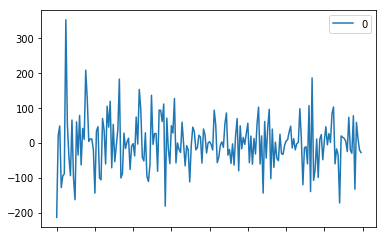

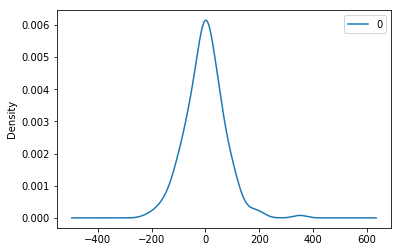

                0
count  200.000000
mean    -1.119009
std     73.603769
min   -214.042152
25%    -44.523345
50%     -0.932543
75%     41.444681
max    351.886108


In [50]:
df_2019_pd=df_2019_agg.toPandas()

data = df_2019_pd['average ride time/seconds']
data.index=df_2019_pd[['Date']]

model = ARIMA(data, order=(5,1,0),dates=df_2019_pd['Date'])
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:        D.rides per day   No. Observations:                  200
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2025.419
Method:                       css-mle   S.D. of innovations           6036.183
Date:                Sat, 23 Nov 2019   AIC                           4064.839
Time:                        01:38:03   BIC                           4087.927
Sample:                    01-15-2019   HQIC                          4074.182
                         - 01-31-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    22.0657    136.824      0.161      0.872    -246.104     290.235
ar.L1.D.rides per day    -0.6505      0.071     -9.191      0.000      -0.789      -0.512
ar.L2.D.

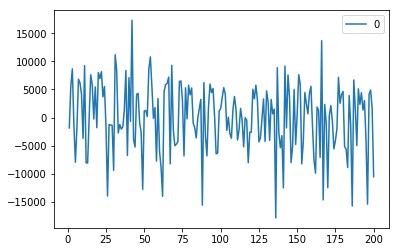

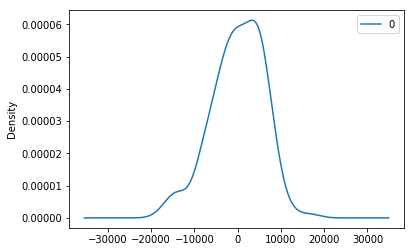

                  0
count    200.000000
mean      27.693583
std     6060.829103
min   -17875.455066
25%    -3913.302790
50%      445.952604
75%     4486.925691
max    17316.357986


In [51]:
data = df_2019_pd[['rides per day']]

model = ARIMA(data.astype(float),order=(5,1,0),dates=df_2019_pd['Date'])
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())